<a href="https://colab.research.google.com/github/MazurovaNN/neural-network/blob/main/lesson6_dz6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow

СЕГМЕНТАЦИЯ


In [48]:
from datasets import load_dataset

dataset = load_dataset("scene_parse_150", split="train")
index = 10
dataset

ModuleNotFoundError: No module named 'datasets'

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
import tensorflow_datasets as С
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

Загрузка датасета

In [4]:
dataset, info = tfds.load('lost_and_found', with_info=True)


Dataset lost_and_found downloaded and prepared to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0. Subsequent calls will reuse this data.


In [5]:
dataset['train']

<_PrefetchDataset element_spec={'image_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None), 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}>

Следующий код выполнит простую аугументацию данных посредством переворота изображений. В дополнение изображение будет нормализовано к 0 и 1. Пиксели сегментационной маски будут помечены {1, 2, 3}, но для удобства из данного цифрового ряда будет вычтено по 1 и в итоге получиться {0, 1, 2}

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
@tf.function
def load_image_train(datapoint):
  for img in datapoint:
    input_image = tf.image.resize(datapoint['image_left'], (240, 320,), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # input_mask = tf.image.resize(datapoint['label'], (240, 320), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      # input_mask = tf.image.flip_left_right(input_mask)

    # input_image = normalize(input_image)

  return input_image #, input_mask

In [8]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image_left'], (128, 128, 3))
  input_mask = tf.image.resize(datapoint['segmentation_label'], (128, 128))
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

Датасет уже содержит необходимые тестовый и тренеровочный сплиты, поэтому давайте использовать их.

In [9]:
import pandas as pd
row_lens = []
col_lens = []
for img in dataset['train']:
  row_lens.append(int(img['image_left'].shape[0]))
  col_lens.append(int(img['image_left'].shape[1]))
t = pd.DataFrame(row_lens, columns=['rows'])
t['cols'] = col_lens

In [10]:
images = []
for img in dataset['train']:
  single_img = img['image_left']
  images.append(single_img)

In [11]:
images[1].shape

TensorShape([1024, 2048, 3])

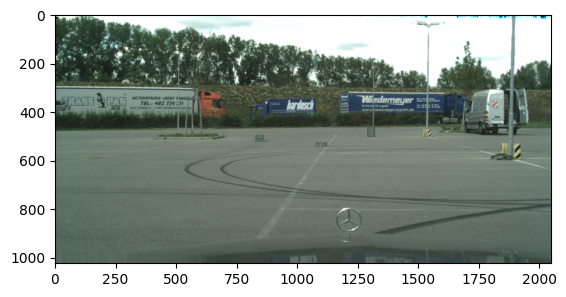

In [12]:
plt.imshow(images[3])
plt.show()

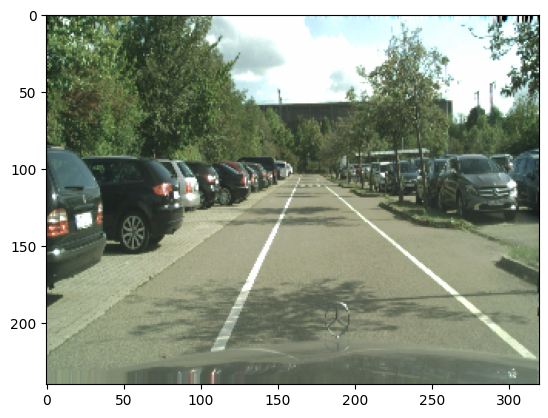

In [13]:
t = tf.image.resize(images[2], (240, 320, ), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
plt.imshow(t[:,:,:])
plt.show()

In [14]:
t.shape

TensorShape([240, 320, 3])

In [15]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [16]:
load_image_train

In [17]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [18]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#test_dataset = test.batch(BATCH_SIZE)

Давайте посмотрим на пример изображения из датасета и соотвествующую ему маску из датасета.

In [19]:
import matplotlib.pyplot as plt

In [20]:
train.take(1)

<_TakeDataset element_spec=TensorSpec(shape=(240, 320, 3), dtype=tf.uint8, name=None)>

In [21]:
def display_images(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i][:,:,:])
    plt.axis('off')

plt.show()


In [22]:
display_list = 0

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

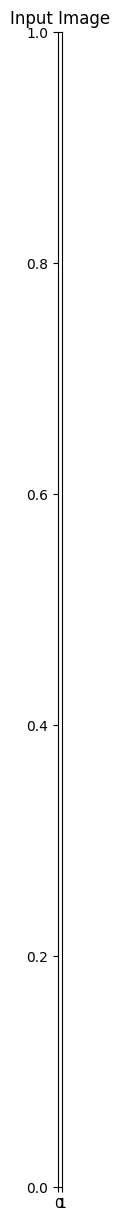

In [23]:
for image in train.take(1):
	sample_image= image
	display_list = sample_image

display_images(display_list)

In [24]:
import os
import seaborn as sns
from tensorflow import keras
import cv2
import PIL
from IPython.display import clear_output

In [25]:
width, height = 224, 224

Определение модели

In [26]:
base_model = keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
                               base_model_outputs)

58889256/58889256 [==============================] - 0s 0us/step


In [27]:
def fcn8_decoder(convs, n_classes):
	f1, f2, f3, f4, p5 = convs

	n = 4096
	c6 = tf.keras.layers.Conv2D(
		n, (7, 7), activation='relu', padding='same',
	name="conv6")(p5)
	c7 = tf.keras.layers.Conv2D(
		n, (1, 1), activation='relu', padding='same',
	name="conv7")(c6)

	f5 = c7

	# upsample the output of the encoder
	# then crop extra pixels that were introduced
	o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
		4, 4), strides=(2, 2), use_bias=False)(f5)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 4 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f4
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 4 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample the resulting tensor of the operation you just did
	o = (tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(4, 4), strides=(2, 2),
	use_bias=False))(o)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 3 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f3
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 3 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample up to the size of the original image
	o = tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(8, 8), strides=(8, 8),
	use_bias=False)(o)

	# append a softmax to get the class probabilities
	o = tf.keras.layers.Activation('softmax')(o)
	return o

In [28]:
def segmentation_model():

	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)

	return model


opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.SparseCategoricalCrossentropy(
				from_logits=True),
			metrics=['accuracy'])


In [29]:
def create_mask(pred_mask):
	pred_mask = tf.argmax(pred_mask, axis=-1)
	pred_mask = pred_mask[..., tf.newaxis]
	return pred_mask[0]


def show_predictions(dataset=None, num=1):
	if dataset:
		for image, mask in dataset.take(num):
			pred_mask = model.predict(image)
			display_images([image[0], mask[0], create_mask(pred_mask)])
	else:
		display_images([sample_image, sample_mask,
						create_mask(model.predict(sample_image[tf.newaxis, ...]))])


show_predictions()


NameError: name 'sample_mask' is not defined

Обучение
Теперь, когда все необходимые функции вместе с моделью созданы, мы будем обучать модель. Мы будем обучать модель в течение 20 эпох и выполним разделение проверки на 5.

In [30]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
						steps_per_epoch=STEPS_PER_EPOCH,
						validation_steps=VALIDATION_STEPS,
						validation_data=test_ds)

NameError: name 'train_ds' is not defined

In [31]:
def compute_metrics(y_true, y_pred):
	'''
	Computes IOU and Dice Score.

	Args:
	y_true (tensor) - ground truth label map
	y_pred (tensor) - predicted label map
	'''

	class_wise_iou = []++++++++++++++++++++++++++++++++++++++++++++++++++++
	class_wise_dice_score = []++++++++++++++++++++

	smoothening_factor = 0.00001

	for i in range(3):
		intersection = np.sum((y_pred == i) * (y_true == i))
		y_true_area = np.sum((y_true == i))++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++=+++++++++++++++++=+++++=+++++++++++++++++++++++++++++++++++++++

SyntaxError: invalid syntax (<ipython-input-31-bda9a49a8f44>, line 10)

In [32]:
def get_test_image_and_annotation_arrays():
	'''
	Unpacks the test dataset and returns
	the input images and segmentation masks
	'''

	ds = test_ds.unbatch()
	ds = ds.batch(info.splits['test'].num_examples)

	images = []
	y_true_segments = []

	for image, annotation in ds.take(1):
		y_true_segments = annotation.numpy()
		images = image.numpy()

	y_true_segments = y_true_segments[:(
		info.splits['test'].num_examples - (info.splits['test']
											.num_examples % BATCH_SIZE))]
	images = images[:(info.splits['test'].num_examples -
					(info.splits['test'].num_examples % BATCH_SIZE))]

	return images, y_true_segments


y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape


def display_prediction(display_list, display_string):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask', 'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.xticks([])
		plt.yticks([])
		if i == 1:
			plt.xlabel(display_string, fontsize=12)
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
	plt.show()


iou, dice_score = compute_metrics(
	y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider],
				y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(display_list[idx],
														i, dc) for idx, (i, dc) in
					enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


# showing predictions with metrics
display_prediction(display_list, display_string)


NameError: name 'test_ds' is not defined

In [33]:
OUTPUT_CHANNELS = 3

Как упоминалось ранее энкодером будет предтренированный MobileNetV2, который подготовлен и готов к использованию - tf.keras.applications. Энкодер состоит из определенных аутпутов из средних слоев модели. Обратите внимание энкодр не будет участвовать в процессе тренировкие модели.

In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


Декодер/апсемплер это просто серия апсемпл блоков имплементированнхы в TensorFlow examples.

In [35]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

NameError: name 'pix2pix' is not defined

In [36]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Тренировка модели

In [37]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='SGD',
              loss=tf.keras.losses.KLDivergence(),
              metrics=['top_k_categorical_accuracy'])

NameError: name 'up_stack' is not defined

Посмотрим на получившуюся архитектуру модели.

In [38]:
pip install pydot

In [39]:
%pip install graphviz

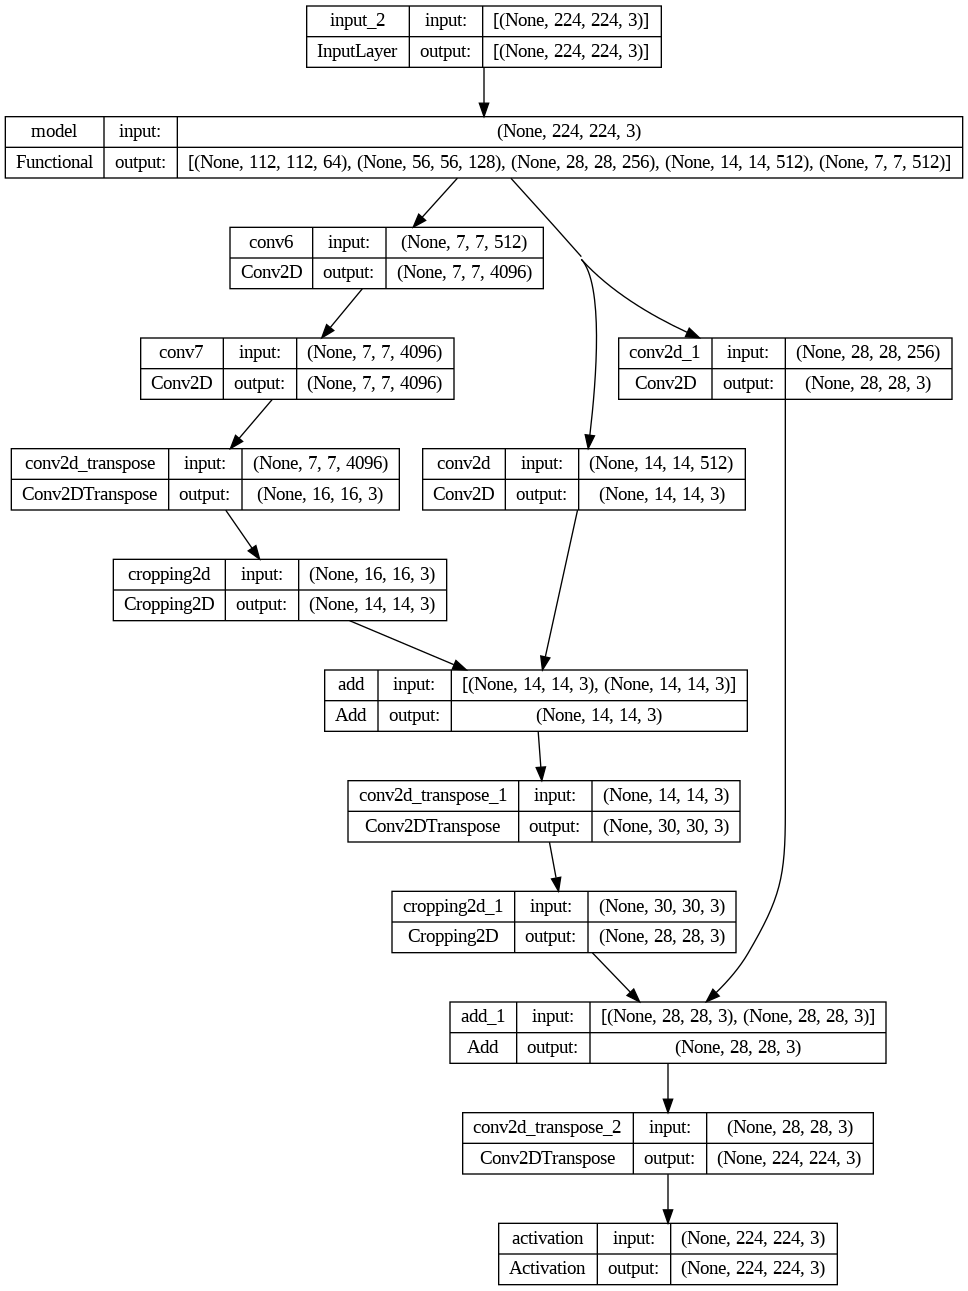

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True)

Давайте попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [41]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [42]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [43]:
show_predictions()

NameError: name 'sample_mask' is not defined

Давайте осуществлять мониторинг того как улучшается работа модели в процессе обучения. Для завершения этой задачи callback функция определена ниже.

In [44]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [45]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

NameError: name 'test_dataset' is not defined

In [46]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

NameError: name 'model_history' is not defined

## Make predictions

Давайте сделаем несколько предсказаний. Для экономии времени использовалось небольшое количество эпох, но вы можете его увеличить для того чтобы модель давала более точные результаты.

In [47]:
show_predictions(test_dataset, 3)

NameError: name 'test_dataset' is not defined

ЛЕКЦИЯ   6


In [49]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

In [50]:
import zipfile

data_r = zipfile.ZipFile('train.zip', 'r')
data_r.extractall()

In [51]:
data_r = zipfile.ZipFile('test.zip', 'r')
data_r.extractall()

In [52]:
def download_data(path):
  data = []
  for path_image in sorted(os.listdir(path=path)):
    image = Image.open(path + path_image) #Открываем изображение.
    data.append(np.array(image)) #Загружаем пиксели.
  return data

In [53]:
X_train = download_data(r"train/images/")
Y_train = download_data(r"train/masks/")
X_test = download_data(r"test/images/")
Y_test = download_data(r"test/masks/")


array([[[177, 181, 184],
        [205, 209, 212],
        [219, 222, 227],
        ...,
        [226, 229, 244],
        [230, 233, 250],
        [243, 246, 255]],

       [[217, 221, 224],
        [244, 248, 251],
        [252, 255, 255],
        ...,
        [229, 232, 247],
        [217, 220, 235],
        [208, 211, 226]],

       [[234, 238, 241],
        [252, 255, 255],
        [250, 253, 255],
        ...,
        [240, 242, 255],
        [237, 239, 252],
        [226, 228, 241]],

       ...,

       [[201, 198, 209],
        [221, 218, 229],
        [221, 215, 225],
        ...,
        [241, 234, 224],
        [255, 250, 240],
        [255, 251, 241]],

       [[194, 191, 202],
        [215, 212, 223],
        [223, 217, 227],
        ...,
        [222, 215, 205],
        [230, 223, 213],
        [223, 216, 206]],

       [[212, 209, 220],
        [195, 192, 203],
        [179, 173, 183],
        ...,
        [240, 233, 223],
        [255, 248, 238],
        [253, 246, 236]]], dtype=uint8)
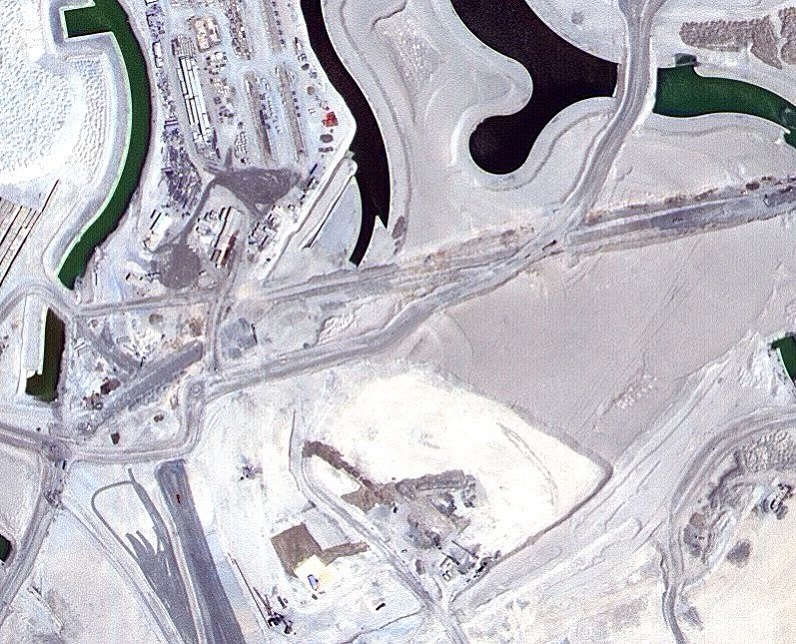

In [54]:
X_train[0]

In [55]:
len(Y_train)

7

In [56]:
len(Y_train[0])

644

In [57]:
len(Y_train[0][0])

796

In [58]:
Y_train[0][0][0]

array([132,  41, 246, 255], dtype=uint8)

In [59]:
len(Y_train[0][0][0])

4

In [60]:
palette = {0 : (60, 16, 152), # Building
           1 : (132, 41, 246), # Land
           2 : (110, 193, 228), # Road
           3 : (254, 221, 58), # Vegetation
           4 : (226, 169, 41), # Water
           5 : (155, 155, 155)} # Unlabeled

In [61]:
invert_palette = {v: k for k, v in palette.items()}

In [62]:
# сегментация нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [63]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8) # принадлежность каждого пикселя классу
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 # расстояние до ближайшего класса для пикселей
    for c, i in palette.items():
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      condition = min_distance > distance # поиск элементов меньше min_distance
      min_distance[condition] = distance[condition] # замена дистанции найденных элементов
      arr_2d[condition] = i # замена класса найденных элементов

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

In [64]:
X_train_pred = np.array(X_train).reshape([7, 644, 796, 3])/255
X_test_pred = np.array(X_test).reshape([2, 644, 796, 3])/255
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)


In [65]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [66]:
def unet_model(image_size, output_classes):

    #Входной слой
    input_layer = Input(shape=image_size + (3,))
    conv_1 = Conv2D(64, 4,
                                    activation=LeakyReLU(),
                                    strides=2, padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(input_layer)
    #Сворачиваем
    conv_1_1 = Conv2D(128, 4,
                                      activation=LeakyReLU(),
                                      strides=2,
                                      padding='same',
                                      kernel_initializer='glorot_normal',
                                      use_bias=False)(conv_1)
    batch_norm_1 = BatchNormalization()(conv_1_1)

    #2
    conv_2 = Conv2D(256, 4,
                                    activation=LeakyReLU(),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_1)
    batch_norm_2 = BatchNormalization()(conv_2)

    #3
    conv_3 = Conv2D(512, 4,
                                    activation=LeakyReLU(),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_2)
    batch_norm_3 = BatchNormalization()(conv_3)

    #4
    conv_4 = Conv2D(512, 4,
                                    activation=LeakyReLU(),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_3)
    batch_norm_4 = BatchNormalization()(conv_4)

    #5
    conv_5 = Conv2D(512, 4,
                                    activation=LeakyReLU(),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    #6
    conv_6 = Conv2D(512, 4,
                                    activation=LeakyReLU(),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_5)
      #Разворачиваем
    #1
    up_1 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(conv_6), conv_5])
    batch_up_1 = BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = Dropout(0.25)(batch_up_1)

    #2
    up_2 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_1), conv_4])
    batch_up_2 = BatchNormalization()(up_2)
    batch_up_2 = Dropout(0.25)(batch_up_2)




    #3
    up_3 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_2), conv_3])
    batch_up_3 = BatchNormalization()(up_3)
    batch_up_3 = Dropout(0.25)(batch_up_3)




    #4
    up_4 = Concatenate()([Conv2DTranspose(256, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_3), conv_2])
    batch_up_4 = BatchNormalization()(up_4)


    #5
    up_5 = Concatenate()([Conv2DTranspose(128, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_4), conv_1_1])
    batch_up_5 = BatchNormalization()(up_5)


    #6
    up_6 = Concatenate()([Conv2DTranspose(64, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_5), conv_1])
    batch_up_6 = BatchNormalization()(up_6)


    #Выходной слой
    output_layer = Conv2DTranspose(output_classes, 4, activation='sigmoid', strides=2,
                                                   padding='same',
                                                   kernel_initializer='glorot_normal')(batch_up_6)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [67]:
from keras.losses import *

In [68]:
import tensorflow as tf

In [69]:
#Функция для подсчёта DICE коэффициента
def dice_coef(y_pred, y_true):
    y_pred = tf.unstack(y_pred, axis=3)
    y_true = tf.unstack(y_true, axis=3)
    dice_summ = 0

    for i, (a_y_pred, b_y_true) in enumerate(zip(y_pred, y_true)):
        dice_calculate = (2 * tf.math.reduce_sum(a_y_pred * b_y_true) + 1) /\
         (tf.math.reduce_sum(a_y_pred + b_y_true) + 1)

        dice_summ += dice_calculate
    avg_dice = dice_summ/CLASSES
    return avg_dice

In [70]:
#Функция для подсчета DICE loss
def dice_loss(y_pred, y_true):
    d_loss = 1 - dice_coef(y_pred, y_true)
    return d_loss

In [71]:
# Binary crossentropy + 0.25 * DICE
def dice_bce_loss(y_pred, y_true):
    total_loss = 0.25 * dice_loss(y_pred, y_true) + keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss